In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import torchvision
import torchsummary
import PIL
from matplotlib import pyplot as plt
import numpy as np

import utils
import datasets
from models import SRCNN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
batch_size = 32
div2k = datasets.Div2K(32, 2)
training_set, validation_set, test_set = torch.utils.data.random_split(div2k, [640,80,80])
# lr, hr = div2k[0]
# print(lr.shape)
# utils.showImages([lr, hr])


In [3]:
training_dataloader = torch.utils.data.DataLoader(training_set, batch_size=batch_size)
validation_dataloader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

model = SRCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0004)
loss_func = torch.nn.MSELoss()

torchsummary.summary(model, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]          15,616
            Conv2d-2           [-1, 32, 64, 64]          51,232
            Conv2d-3            [-1, 3, 64, 64]           2,403
Total params: 69,251
Trainable params: 69,251
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 3.09
Params size (MB): 0.26
Estimated Total Size (MB): 3.40
----------------------------------------------------------------


In [4]:
# basic training loop
for epoch in range(16):
    for i, batch in enumerate(training_dataloader):
        optimizer.zero_grad()

        lr, hr = batch
        lr, hr = lr.to(device), hr.to(device)
        with torch.no_grad():
            upscaled = torchvision.transforms.functional.resize(lr, (64,64))

        pred = model(upscaled)
        loss = loss_func(pred, hr)
        loss.backward()

        optimizer.step()

        #print(i, loss)
    # basic validation loop
    print(f"Epoch {epoch}")
    for i, batch in enumerate(validation_dataloader):
        with torch.no_grad():
            lr, hr = batch
            lr, hr = lr.to(device), hr.to(device)
            with torch.no_grad():
                upscaled = torchvision.transforms.functional.resize(lr, (64,64))

            pred = model(upscaled)
            loss = loss_func(pred, hr)
            print(i, loss)

Epoch 0
0 tensor(0.0293, device='cuda:0')
1 tensor(0.0248, device='cuda:0')
2 tensor(0.0263, device='cuda:0')
Epoch 1
0 tensor(0.0147, device='cuda:0')
1 tensor(0.0109, device='cuda:0')
2 tensor(0.0141, device='cuda:0')
Epoch 2
0 tensor(0.0090, device='cuda:0')
1 tensor(0.0070, device='cuda:0')
2 tensor(0.0103, device='cuda:0')
Epoch 3
0 tensor(0.0065, device='cuda:0')
1 tensor(0.0048, device='cuda:0')
2 tensor(0.0079, device='cuda:0')
Epoch 4
0 tensor(0.0053, device='cuda:0')
1 tensor(0.0038, device='cuda:0')
2 tensor(0.0068, device='cuda:0')
Epoch 5
0 tensor(0.0047, device='cuda:0')
1 tensor(0.0034, device='cuda:0')
2 tensor(0.0063, device='cuda:0')
Epoch 6
0 tensor(0.0042, device='cuda:0')
1 tensor(0.0030, device='cuda:0')
2 tensor(0.0058, device='cuda:0')
Epoch 7
0 tensor(0.0039, device='cuda:0')
1 tensor(0.0029, device='cuda:0')
2 tensor(0.0056, device='cuda:0')
Epoch 8
0 tensor(0.0036, device='cuda:0')
1 tensor(0.0027, device='cuda:0')
2 tensor(0.0054, device='cuda:0')
Epoch 9
0 

In [5]:
# basic testing loop
print("Testing")
for i, batch in enumerate(test_dataloader):
    with torch.no_grad():
        lr, hr = batch
        lr, hr = lr.to(device), hr.to(device)
        with torch.no_grad():
            upscaled = torchvision.transforms.functional.resize(lr, (64,64))

        pred = model(upscaled)
        loss = loss_func(pred, hr)
        print(i, loss)

Testing
0 tensor(0.0034, device='cuda:0')
1 tensor(0.0032, device='cuda:0')
2 tensor(0.0032, device='cuda:0')


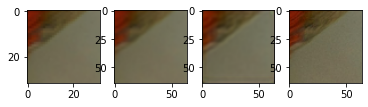

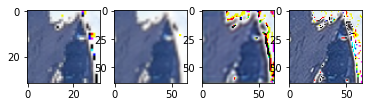

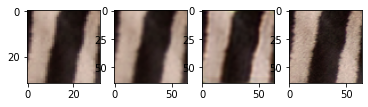

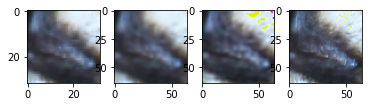

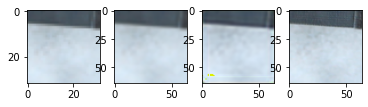

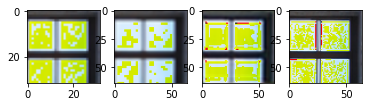

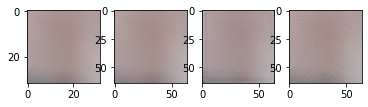

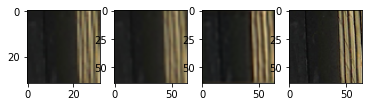

In [16]:
for i in range(8):
    with torch.no_grad():
        lr, hr = test_set[i]
        upscaled = torchvision.transforms.functional.resize(torch.Tensor(lr), (64,64)).to(device)
        pred = np.asarray(model(utils.example_batch(upscaled, batch_size))[0].cpu())
        upscaled = np.asarray(upscaled.cpu())
        utils.showImages([lr, upscaled, pred, hr])